## Example. Estimating the speed of light

Simon Newcomb's measurements of the speed of light, from

> Stigler, S. M. (1977). Do robust estimators work with real data? (with discussion). *Annals of
Statistics* **5**, 1055–1098. 

The data are recorded as deviations from $24\ 800$
nanoseconds.  Table 3.1 of Bayesian Data Analysis.

28 26 33 24 34 -44 27 16 40 -2
29 22 24 21 25 30 23 29 31 19
24 20 36 32 36 28 25 21 28 29
37 25 28 26 30 32 36 26 30 22
36 23 27 27 28 27 31 27 26 33
26 32 32 24 39 28 24 25 32 25
29 27 28 29 16 23

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

from scipy.optimize import brentq

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [70]:
numbs = "28 26 33 24 34 -44 27 16 40 -2 29 22 \
24 21 25 30 23 29 31 19 24 20 36 32 36 28 25 21 28 29 \
37 25 28 26 30 32 36 26 30 22 36 23 27 27 28 27 31 27 26 \
33 26 32 32 24 39 28 24 25 32 25 29 27 28 29 16 23"

In [71]:
nums = np.array([int(i) for i in numbs.split(' ')])

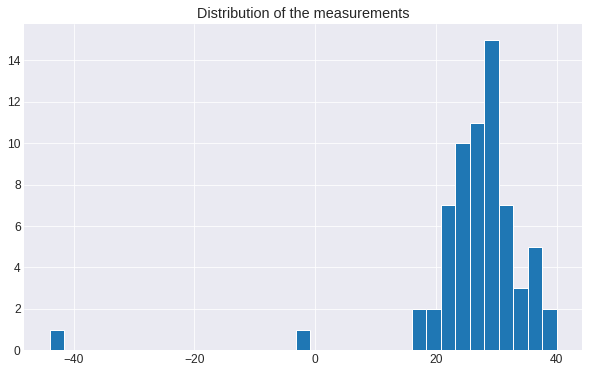

In [72]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(nums, bins=35, edgecolor='w')
plt.title('Distribution of the measurements');

In [73]:
mean_t = np.mean(nums)
print(f'The mean of the 66 measurements is {mean_t:.1f}')

The mean of the 66 measurements is 26.2


In [74]:
std_t = np.std(nums, ddof=1)
print(f'The standard deviation of the 66 measurements is {std_t:.1f}')

The standard deviation of the 66 measurements is 10.7


And now, we use `pymc3` to estimate the mean and the standard deviation from the data.

In [75]:
with pm.Model() as model_1:
    mu = pm.Uniform('mu', lower=10, upper=30)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    post = pm.Normal('post', mu=mu, sd=sigma, observed=nums)

In [76]:
with model_1:
    trace_1 = pm.sample(draws=50_000, tune=50_000, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 400000/400000 [02:49<00:00, 2363.42draws/s]


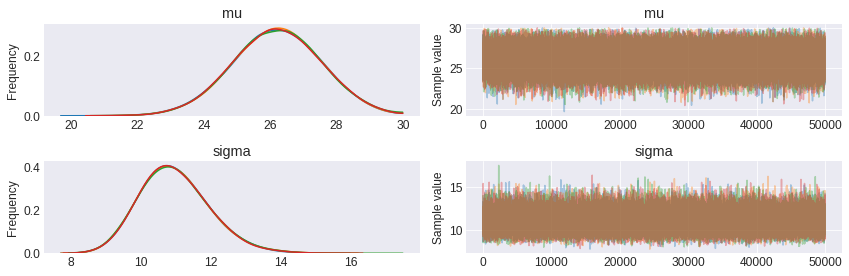

In [77]:
pm.traceplot(trace_1);

In [78]:
df = pm.summary(trace_1)
df.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,26.2015,1.3370,0.0038,23.5946,28.8455,89258.0649,1.0000
sigma,10.9616,0.9863,0.0027,9.1066,12.9109,101730.4211,1.0000


As you can see, the highest posterior interval for `mu` is [23.57, 28.82].

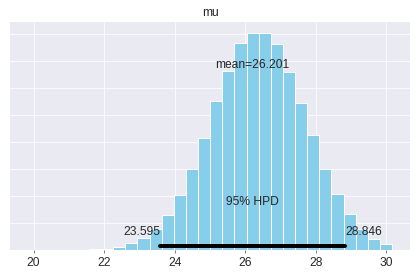

In [79]:
pm.plot_posterior(trace_1, varnames=['mu']);

The true posterior distribution is $t_{65}$

In [80]:
from scipy.stats import t

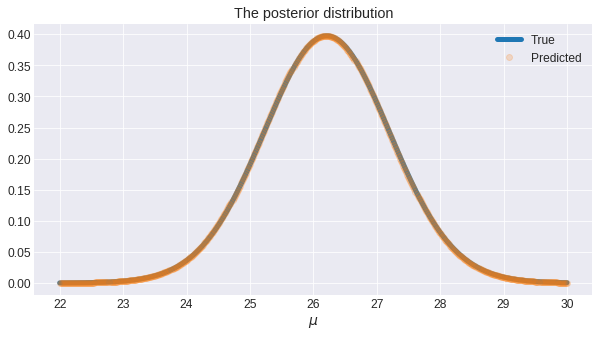

In [81]:
x = np.linspace(22, 30, 500)
y = t.pdf(x, 65, loc=mean_t)

y_pred = t.pdf(x, 65, loc=df['mean'].values[0])

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True', linewidth=5)
plt.plot(x, y_pred, 'o', label='Predicted', alpha=0.2)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\mu$', fontsize=14);

The book says you can find the posterior interval by simulation, so let's do that with Python. First, draw random values of $\sigma^2$ and $\mu$.

In [82]:
mu_estim = []

for i in range(10_000):
    y = np.random.chisquare(65)
    y2 = 65 * std_t**2 / y
    yy = np.random.normal(loc=mean_t, scale=y2/66)
    mu_estim.append(yy)

To visualize `mu_estim`, we plot a histogram.

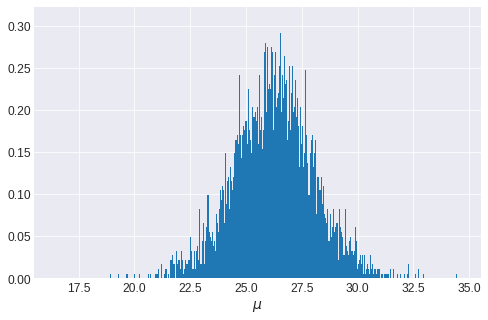

In [83]:
plt.figure(figsize=(8,5))
rang, bins1, _ = plt.hist(mu_estim, bins=1000, density=True)
plt.xlabel(r'$\mu$', fontsize=14);

The advantage here is that you can find the median and the central posterior interval. Well, the median is...

In [84]:
idx = bins1.shape[0] // 2
print((bins1[idx] + bins1[idx + 1]) / 2) 

25.52496237247784


And the central posterior interval is... not that easy to find. We have to find $a$ such as:

$$\int_{\mu -a}^{\mu +a} f(x)\, dx = 0.95,$$

with $\mu$ the median. We need to define $dx$ and $f(x)$. 


In [85]:
delta_bin = bins1[1] - bins1[0]
print(f'This is delta x: {delta_bin}')

This is delta x: 0.018177092130024164


We define a function to find $a$ (in fact, $a$ is an index). `rang` is $f(x)$.

In [86]:
def func3(a):
    return sum(rang[idx - int(a):idx + int(a)] * delta_bin) - 0.95

In [87]:
idx_sol = brentq(func3, 0, idx)
idx_sol

215.00000000000085

That number is an index, therefore the interval is:

In [88]:
l_i = bins1[idx - int(idx_sol)]
l_d = bins1[idx + int(idx_sol)]

print(f'The central posterior interval is [{l_i:.2f}, {l_d:.2f}]')

The central posterior interval is [21.61, 29.42]


## Example. Pre-election polling

Let's put that in code.

In [89]:
obs = np.array([727, 583, 137])
bush_supp = obs[0] / sum(obs)
dukakis_supp = obs[1] / sum(obs)
other_supp = obs[2] / sum(obs)

arr = np.array([bush_supp, dukakis_supp, other_supp])
print('The proportion array is', arr)
print('The supporters array is', obs)

The proportion array is [0.5024188  0.40290256 0.09467865]
The supporters array is [727 583 137]


Remember that we want to find the distribution of $\theta_1 - \theta_2$. In this case, the prior distribution on each $\theta$ is a uniform distribution; the data $(y_1, y_2, y_3)$ follow a multinomial distribution, with parameters $(\theta_1, \theta_2, \theta_3)$.

In [90]:
import theano
import theano.tensor as tt

In [91]:
with pm.Model() as model_3:

    theta1 = pm.Uniform('theta1', lower=0, upper=1)
    theta2 = pm.Uniform('theta2', lower=0, upper=1)
    theta3 = pm.Uniform('theta3', lower=0, upper=1)
    post = pm.Multinomial('post', n=obs.sum(), p=[theta1, theta2, theta3], observed=obs)
    
    diff = pm.Deterministic('diff', theta1 - theta2)

In [92]:
model_3.check_test_point()

theta1_interval__     -1.39
theta2_interval__     -1.39
theta3_interval__     -1.39
post                -243.49
Name: Log-probability of test_point, dtype: float64

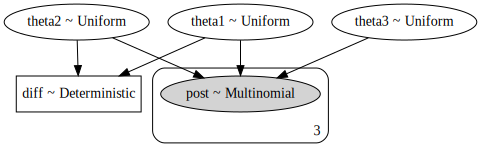

In [93]:
pm.model_to_graphviz(model_3)

In [94]:
with model_3:
    trace_3 = pm.sample(draws=50_000, tune=50_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta3, theta2, theta1]
Sampling 4 chains: 100%|██████████| 400000/400000 [04:58<00:00, 1340.19draws/s]
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1890 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6375738451012264, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.692957727197454, but should be close to 0.8. Try to increase the number of tuning steps.
There were 974 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


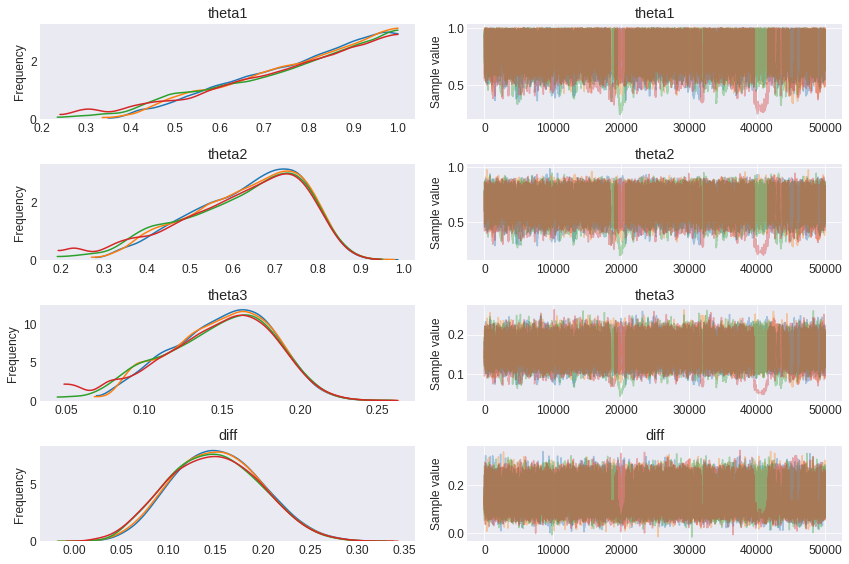

In [95]:
pm.traceplot(trace_3);

In [96]:
pm.summary(trace_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.776983,0.164139,0.005808,0.467561,0.999930,608.676923,1.002710
theta2,0.626853,0.136953,0.004751,0.354063,0.848977,634.954128,1.002606
theta3,0.148303,0.034074,0.001137,0.079501,0.207094,695.802818,1.002212
diff,0.150130,0.047698,0.001061,0.061650,0.243963,1663.725420,1.001060


In [97]:
pm.diagnostics.effective_n(trace_3)

{'theta1': 608.676923009132,
 'theta2': 634.9541281454558,
 'theta3': 695.8028180144568,
 'diff': 1663.7254203905536}

As you can see, the way we write the model is not good, that's why you see a lot of divergences and `n_eff` (the effective sample size) is very, very low. This can be improved.

In [98]:
with pm.Model() as model_4:
    theta = pm.Dirichlet('theta', a=np.ones_like(obs))
    post = pm.Multinomial('post', n=obs.sum(), p=theta, observed=obs)

In [99]:
with model_4:
    trace_4 = pm.sample(10_000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:22<00:00, 2627.92draws/s]


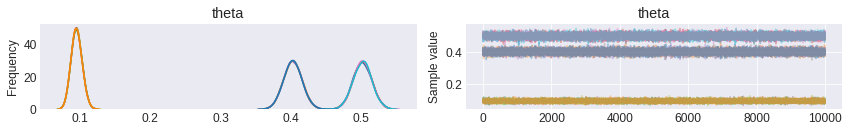

In [100]:
pm.traceplot(trace_4);

In [101]:
pm.summary(trace_4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.501985,0.013147,0.000074,0.476491,0.528278,40591.175375,0.999997
theta__1,0.402864,0.012914,0.000072,0.377807,0.428380,39911.443933,1.000001
theta__2,0.095151,0.007751,0.000042,0.079889,0.110155,39580.482525,0.999983


Better trace plot and better `n_eff`. Now we can estimate $\theta_1 - \theta_2$, we draw 4000 points from the posterior distribution.

In [102]:
post_samples = pm.sample_ppc(trace_4, samples=4_000, model=model_4)

100%|██████████| 4000/4000 [00:03<00:00, 1093.20it/s]


In [103]:
diff = []
sum_post_sample = post_samples['post'].sum(axis=1)[0]

for i in range(post_samples['post'].shape[0]):
    diff.append((post_samples['post'][i, 0] - 
                post_samples['post'][i, 1]) /  sum_post_sample)

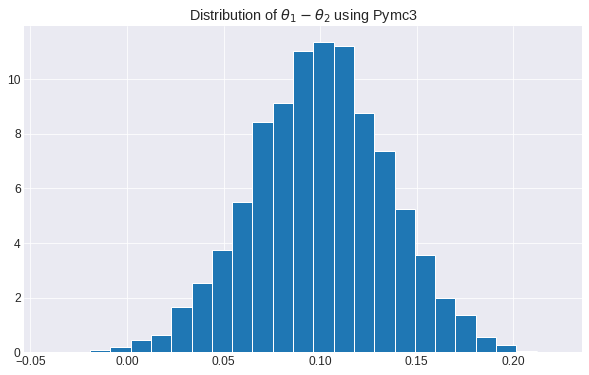

In [104]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(diff, bins=25, edgecolor='w', density=True)
plt.title(r'Distribution of $\theta_1 - \theta_2$ using Pymc3');

Of course you can compare this result with the true posterior distribution

In [105]:
from scipy.stats import dirichlet

In [106]:
ddd = dirichlet([728, 584, 138])

rad = []
for i in range(4_000):
    rad.append(ddd.rvs()[0][0] - ddd.rvs()[0][1])

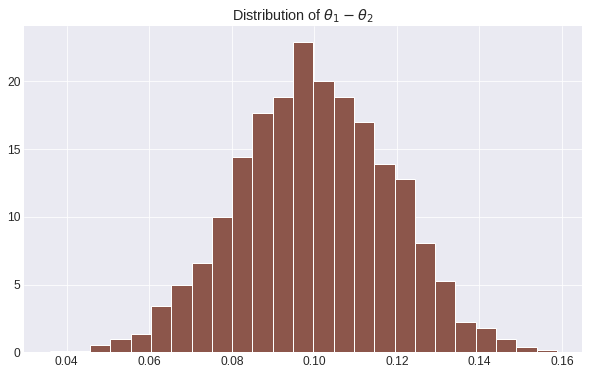

In [107]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(rad, color='C5', bins=25, edgecolor='w', density=True)
plt.title(r'Distribution of $\theta_1 - \theta_2$');

/home/rosgori/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


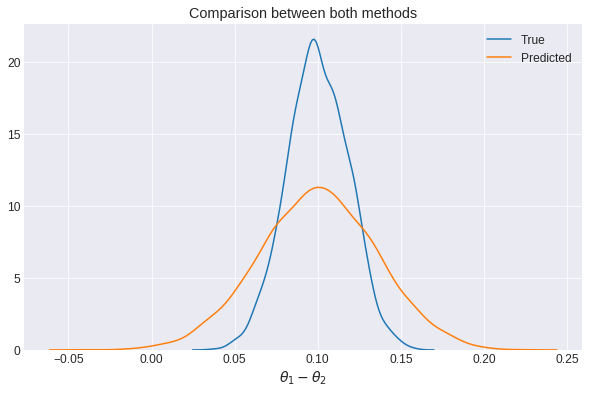

In [108]:
plt.figure(figsize=(10, 6))
sns.kdeplot(rad, label='True')
sns.kdeplot(diff, label='Predicted');
plt.title('Comparison between both methods')
plt.xlabel(r'$\theta_1 - \theta_2$', fontsize=14);

## Example: analysis of a bioassay experiment

This information is in Table 3.1

In [3]:
x_dose = np.array([-0.86, -0.3, -0.05, 0.73])
n_anim = np.array([5, 5, 5, 5])
y_deat = np.array([0, 1, 3, 5])

In [4]:
with pm.Model() as model_5:
    alpha = pm.Uniform('alpha', lower=-5, upper=7)
    beta = pm.Uniform('beta', lower=0, upper=50)
    
    theta = pm.math.invlogit(alpha + beta * x_dose)
    
    post = pm.Binomial('post', n=n_anim, p=theta, observed=y_deat)

In [5]:
with model_5:
    trace_5 = pm.sample(draws=10_000, tune=15_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:37<00:00, 2691.95draws/s]
The acceptance probability does not match the target. It is 0.8831399668687998, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943205520787431, but should be close to 0.8. Try to increase the number of tuning steps.


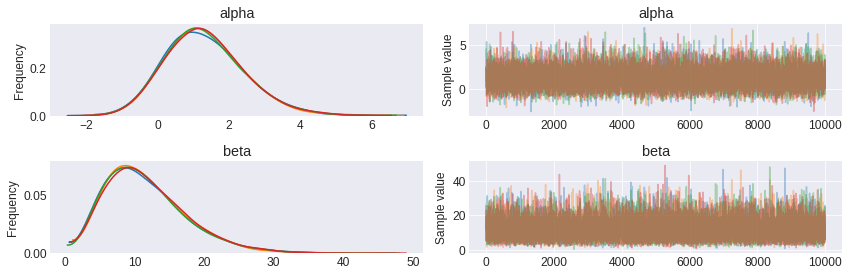

In [6]:
pm.traceplot(trace_5);

In [7]:
df5 = pm.summary(trace_5)
df5.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.3238,1.1092,0.0103,-0.7944,3.4760,11961.0428,1.0001
beta,11.6495,5.7745,0.0552,2.5300,23.1277,12701.3707,1.0001


The next plots are a scatter plot, a plot for the posterior for `alpha` and `beta` and a countour plot.

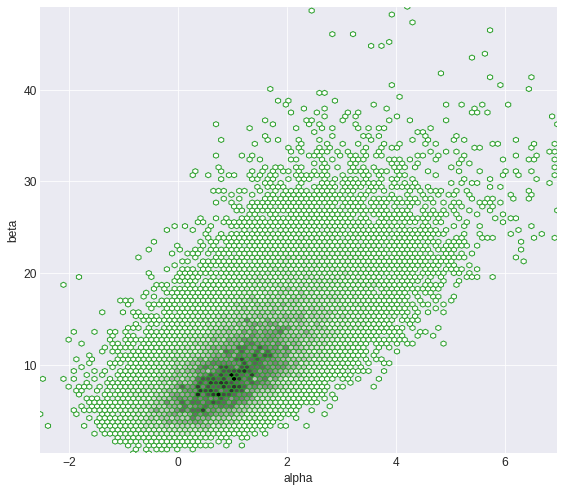

In [8]:
pm.pairplot(trace_5, figsize=(8, 7), divergences=True,
            color='C2', hexbin=True);

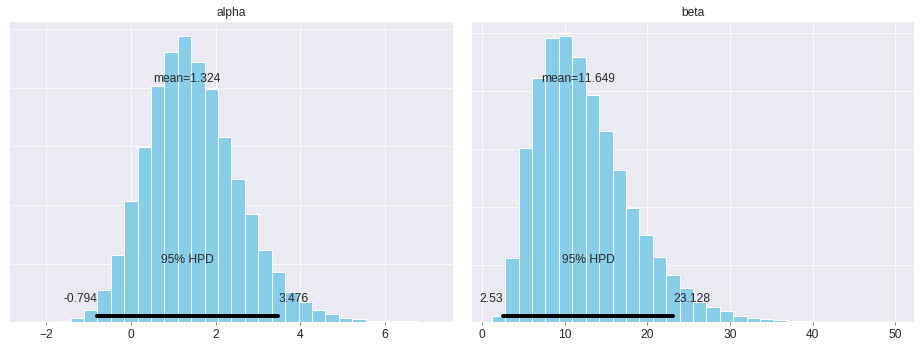

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13, 5))
pm.plot_posterior(trace_5, ax=ax);

/home/rosgori/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


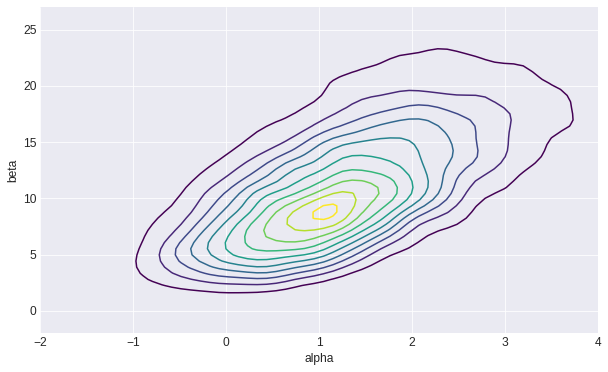

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(trace_5['alpha'][30000:40000], trace_5['beta'][30000:40000], 
            cmap=plt.cm.viridis, ax=ax, n_levels=10)
ax.set_xlim(-2, 4)
ax.set_ylim(-2, 27)
ax.set_xlabel('alpha')
ax.set_ylabel('beta');

Histogram of the draws from the posterior distribution of the LD50

In [11]:
ld50 = []

begi = 1500
for i in range(1000):
    ld50.append( - trace_5['alpha'][begi + i] / trace_5['beta'][begi + i])

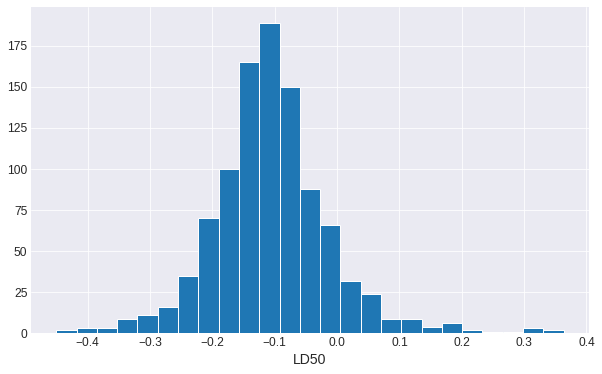

In [12]:
plt.figure(figsize=(10, 6))
_, _, _, = plt.hist(ld50, bins=25, edgecolor='w')
plt.xlabel('LD50', fontsize=14);

In [13]:
%load_ext watermark

In [14]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy       1.15.0
pymc3       3.5
seaborn     0.9.0
CPython 3.6.6
IPython 7.1.1

theano 1.0.2
scipy 1.1.0
matplotlib 2.2.3

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.0-138-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
